In [32]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import torch
from torch.utils.data import random_split, DataLoader
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix

from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### **Loading Dataset**

In [33]:
train_dataset = MNIST(root='./data',
                        train=True, 
                        transform=transforms.ToTensor(),
                        download=False)

In [34]:
test_dataset = MNIST(root='./data',
                     train=False,
                     transform=transforms.ToTensor())

### **Separating the Dataset**

In [35]:
train_size = int(len(train_dataset) * 0.9)

In [36]:
val_size = int(len(train_dataset) * 0.1)

In [37]:
torch.manual_seed(27)

In [38]:
train_dataset, val_dataset = random_split(dataset=train_dataset, lengths=[train_size, val_size])

### **Creating the Dataloader**

In [39]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=32,
                              shuffle=True, 
                              num_workers=2)

In [40]:
test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=32,
                             shuffle=False,
                             num_workers=2)

In [41]:
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=32,
                            shuffle=False,
                            num_workers=2)

### **Analysis of Class Distribution**

#### **Train**

In [42]:
train_counter = Counter()

for _, y in train_dataloader:
    train_counter.update(y.tolist())

In [43]:
print("Train class distribution: ", sorted(train_counter.items()))

Train class distribution:  [(0, 5370), (1, 6066), (2, 5366), (3, 5520), (4, 5277), (5, 4857), (6, 5318), (7, 5624), (8, 5245), (9, 5357)]


#### **Test**

In [44]:
test_counter = Counter()

for _, y in test_dataloader:
    test_counter.update(y.tolist())

In [45]:
print("Test class distribution: ", sorted(test_counter.items()))

Test class distribution:  [(0, 980), (1, 1135), (2, 1032), (3, 1010), (4, 982), (5, 892), (6, 958), (7, 1028), (8, 974), (9, 1009)]


#### **Val**

In [46]:
val_counter = Counter()

for _, y in val_dataloader:
    val_counter.update(y.tolist())

In [47]:
print("Val class distribution: ", sorted(val_counter.items()))

Val class distribution:  [(0, 553), (1, 676), (2, 592), (3, 611), (4, 565), (5, 564), (6, 600), (7, 641), (8, 606), (9, 592)]


### **View some Data**

In [48]:
for x, _ in train_dataloader:
    break

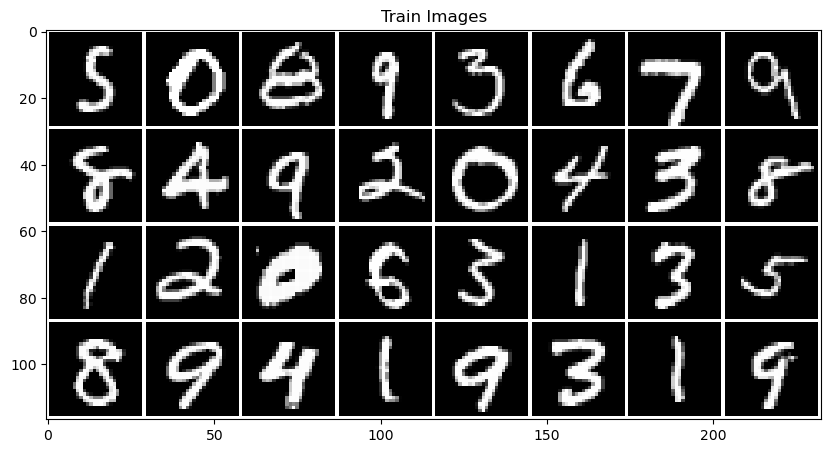

In [49]:
plt.figure(figsize=(10,10))
plt.title("Train Images")
plt.imshow(np.transpose(make_grid(x,
                                  padding=1,
                                  normalize=True,
                                  pad_value=1.0),
                        (1,2,0)))

### **MLP**

In [50]:
class MLP(torch.nn.Module):

    def __init__(self, num_features):
        super().__init__()
        
        self.cnn_layers = torch.nn.Sequential(
            torch.nn.Conv2d(1, 3, kernel_size=5),
            torch.nn.BatchNorm2d(3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),

            torch.nn.Conv2d(3, 9, kernel_size=3),
            torch.nn.BatchNorm2d(9),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),

            torch.nn.Conv2d(9, 21, kernel_size=3),
            torch.nn.BatchNorm2d(21),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )

        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(21, 32),
            torch.nn.BatchNorm1d(32),
            torch.nn.ReLU(),

            torch.nn.Linear(32, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),

            torch.nn.Linear(64, 32),
            torch.nn.BatchNorm1d(32),
            torch.nn.ReLU(),

            torch.nn.Linear(32, num_features)
        )

    def forward(self, x):
        x = self.cnn_layers(x)

        return self.fc_layers(torch.flatten(x, start_dim=1))

In [51]:
model = MLP(num_features=10).to('cuda')

### **Traning**

In [52]:
def accuracy(model, dataloader):
    model.eval()

    accuracy_val = 0.0
    total = 0

    for x,y in dataloader:
        x = x.to('cuda')
        y = y.to('cuda')

        with torch.inference_mode():
            z = model(x)

        labels = torch.argmax(z, dim=1)
        labels = labels.view(y.shape).to(y.dtype)

        results = labels == y
        accuracy_val += results.sum().item()
        total += results.numel()
    
    return accuracy_val/total

In [53]:
optimizer = torch.optim.SGD(model.parameters(), lr=1.0)

In [54]:
epochs = 10

In [55]:
for epoch in range(epochs):
    model.train()

    for idx, (x, y) in enumerate(train_dataloader):
        x = x.to('cuda')
        y = y.to('cuda')
        
        z = model(x)
        loss = F.cross_entropy(z, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if idx % 200 == 0:
            print(f'Epoch: {epoch + 1:03d}/{epochs} - Batch: {idx + 1:03d}/{len(train_dataloader)} - Loss: {loss:0.3f}')
    
    test_accuracy = accuracy(model, test_dataloader)
    val_accuracy = accuracy(model, val_dataloader)

    print(f'Test accuracy: {test_accuracy*100:0.2f}% - Val accuracy: {val_accuracy*100:0.2f}%')

Epoch: 001/10 - Batch: 001/1688 - Loss: 2.452
Epoch: 001/10 - Batch: 201/1688 - Loss: 0.603
Epoch: 001/10 - Batch: 401/1688 - Loss: 0.426
Epoch: 001/10 - Batch: 601/1688 - Loss: 0.435
Epoch: 001/10 - Batch: 801/1688 - Loss: 0.136
Epoch: 001/10 - Batch: 1001/1688 - Loss: 0.054
Epoch: 001/10 - Batch: 1201/1688 - Loss: 0.188
Epoch: 001/10 - Batch: 1401/1688 - Loss: 0.379
Epoch: 001/10 - Batch: 1601/1688 - Loss: 0.251
Test accuracy: 94.90% - Val accuracy: 95.32%
Epoch: 002/10 - Batch: 001/1688 - Loss: 0.097
Epoch: 002/10 - Batch: 201/1688 - Loss: 0.247
Epoch: 002/10 - Batch: 401/1688 - Loss: 0.149
Epoch: 002/10 - Batch: 601/1688 - Loss: 0.189
Epoch: 002/10 - Batch: 801/1688 - Loss: 0.250
Epoch: 002/10 - Batch: 1001/1688 - Loss: 0.240
Epoch: 002/10 - Batch: 1201/1688 - Loss: 0.282
Epoch: 002/10 - Batch: 1401/1688 - Loss: 0.120
Epoch: 002/10 - Batch: 1601/1688 - Loss: 0.337
Test accuracy: 96.86% - Val accuracy: 96.87%
Epoch: 003/10 - Batch: 001/1688 - Loss: 0.403
Epoch: 003/10 - Batch: 201/1

### **Evaluating the Results**

In [56]:
print(f"Test accuracy: {accuracy(model, test_dataloader)*100:0.2f}%")

Test accuracy: 98.20%


In [57]:
def show_confusion_matrix(model, dataloader):
    y_pred = []
    y_true = []

    model.eval()

    for x, y in dataloader:
        x = x.to('cuda')
        y = y.to('cuda')

        with torch.inference_mode():
            z = model(x)
        
        pred = torch.argmax(z, dim=1)
        pred = pred.view(y.shape).to(y.dtype)

        y_pred.extend(pred.tolist())
        y_true.extend(y.tolist())
    
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    plt.title('Matriz de Confusão')
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()

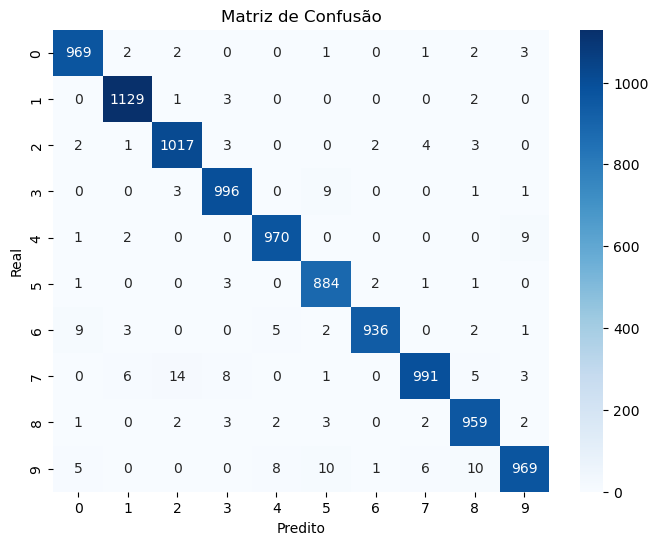

In [58]:
show_confusion_matrix(model, test_dataloader)